Sometimes importing sodapy would not work without the cell below

In [2]:
pip install sodapy

Import necessary Libraries


In [ ]:
### Libraries utilized
import glob
import pandas as pd
from pandas.api.types import CategoricalDtype
import os
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, adjusted_rand_score, normalized_mutual_info_score
import joblib

Import Fresh Dataset using API token

In [ ]:
### Same method of datapull as question 1 from project 1. Pulls data in batches and then combines them using glob.
### Individual batches are then tossed.
APP_TOKEN = "oMcgh3hh3fn1djGiFPyKWrPoC"
client = Socrata("data.cityofnewyork.us", app_token = APP_TOKEN)
DATASET_ID = "w2pb-icbu"
BATCH_SIZE = 50000
offset = 0
batch_num = 0
while True:
    print (f"Fetching rows {offset} to {offset + BATCH_SIZE}...")

    results= client.get(DATASET_ID, limit = BATCH_SIZE, offset=offset)

    if not results :
        print("No more records to fetch.")
        break
    df=pd.DataFrame.from_records(results)

    output_filename = (f"nyc_data_batch_{batch_num:03d}.csv")
    df.to_csv(output_filename, index = False)
    print(f"saved {len(df)} rows to {output_filename}")

    offset += BATCH_SIZE
    batch_num +=1
csv_files = sorted(glob.glob("nyc_data_batch_*.csv"))
print(f"found{len(csv_files)} files to merge.")
df_iter = (pd.read_csv(f) for f in csv_files)
print("Merging all batches into one DataFrame...")
merged_df = pd.concat(df_iter, ignore_index = False)

output_file = "nyc_data_all.csv"
merged_df.to_csv(output_file, index = False)
print(f"Saved merged data to {output_file}")
csv_files = glob.glob("nyc_data_batch_*.csv")

for f in csv_files:
    os.remove(f)
    print (f"Deleted {f}")
print("All batches have been deleted")

Fetching rows 0 to 50000...
saved 50000 rows to nyc_data_batch_000.csv
Fetching rows 50000 to 100000...
saved 50000 rows to nyc_data_batch_001.csv
Fetching rows 100000 to 150000...
saved 50000 rows to nyc_data_batch_002.csv
Fetching rows 150000 to 200000...
saved 50000 rows to nyc_data_batch_003.csv
Fetching rows 200000 to 250000...
saved 50000 rows to nyc_data_batch_004.csv
Fetching rows 250000 to 300000...
saved 50000 rows to nyc_data_batch_005.csv
Fetching rows 300000 to 350000...
saved 50000 rows to nyc_data_batch_006.csv
Fetching rows 350000 to 400000...
saved 50000 rows to nyc_data_batch_007.csv
Fetching rows 400000 to 450000...
saved 50000 rows to nyc_data_batch_008.csv
Fetching rows 450000 to 500000...
saved 50000 rows to nyc_data_batch_009.csv
Fetching rows 500000 to 550000...
saved 50000 rows to nyc_data_batch_010.csv
Fetching rows 550000 to 600000...
saved 50000 rows to nyc_data_batch_011.csv
Fetching rows 600000 to 650000...
saved 50000 rows to nyc_data_batch_012.csv
Fetchi

Reads CSV File into a pandas dataframe

In [ ]:
### Reads in CSV file
df = pd.read_csv("nyc_data_all.csv")

/tmp/ipython-input-428643222.py:1: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("nyc_data_all.csv")


Analyzes the dataframes so that critical columns can be selected

In [ ]:
### A view to see the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760914 entries, 0 to 760913
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   borough                     760914 non-null  int64  
 1   neighborhood                760914 non-null  object 
 2   building_class_category     760914 non-null  object 
 3   tax_class_as_of_final_roll  756731 non-null  object 
 4   block                       760914 non-null  int64  
 5   lot                         760914 non-null  int64  
 6   building_class_as_of_final  756731 non-null  object 
 7   address                     760914 non-null  object 
 8   apartment_number            187994 non-null  object 
 9   zip_code                    760866 non-null  float64
 10  residential_units           647911 non-null  float64
 11  commercial_units            584372 non-null  float64
 12  total_units                 659062 non-null  float64
 13  land_square_fe

In [ ]:
### Picks out columns that are critical for the analysis.
critical_columns = ['total_units', 'borough', 'neighborhood', "zip_code", "total_units", "land_square_feet", "gross_square_feet", "year_built", "sale_price", "sale_date"]
### Creates a new dataframe out of the critical columns.
df_crit = df[critical_columns].copy()

Tests to see the name and associated neighborhood for the borough

In [ ]:
### For loop used to check the neighborhood within each borough for mapping purposes.
for b, group in df_crit.groupby('borough')['neighborhood']:
    print(f"\n{b}:")
    print(sorted(group.unique()))


1:
['ALPHABET CITY', 'CHELSEA', 'CHINATOWN', 'CIVIC CENTER', 'CLINTON', 'EAST VILLAGE', 'FASHION', 'FINANCIAL', 'FLATIRON', 'GRAMERCY', 'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST', 'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'HARLEM-WEST', 'INWOOD', 'JAVITS CENTER', 'KIPS BAY', 'LITTLE ITALY', 'LOWER EAST SIDE', 'MANHATTAN VALLEY', 'MANHATTAN-UNKNOWN', 'MIDTOWN CBD', 'MIDTOWN EAST', 'MIDTOWN WEST', 'MORNINGSIDE HEIGHTS', 'MURRAY HILL', 'ROOSEVELT ISLAND', 'SOHO', 'SOUTHBRIDGE', 'TRIBECA', 'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)', 'UPPER EAST SIDE (96-110)', 'UPPER WEST SIDE (59-79)', 'UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE (96-116)', 'WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS UPPER']

2:
['BATHGATE', 'BAYCHESTER', 'BEDFORD PARK/NORWOOD', 'BELMONT', 'BRONX PARK', 'BRONX-UNKNOWN', 'BRONXDALE', 'CASTLE HILL/UNIONPORT', 'CITY ISLAND', 'CITY ISLAND-PELHAM STRIP', 'CO-OP CITY', 'COUNTRY CLUB', 'CROTONA PARK', 'EAST RIVER', 'EAST TREMONT', 'FIELDSTON', 'FO

Changes borough mapping from a number to numeric convention

In [ ]:
### Creates a dictonary to map each number to the associated borough.
borough_map = {
    1: 'Manhattan',
    2: 'Bronx',
    3: 'Brooklyn',
    4: 'Queens',
    5: 'Staten Island'
}

df_crit['borough'] = df_crit['borough'].map(borough_map)

In [ ]:
### Views the dataframe
df_crit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760914 entries, 0 to 760913
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   total_units        659062 non-null  float64
 1   borough            760914 non-null  object 
 2   neighborhood       760914 non-null  object 
 3   zip_code           760866 non-null  float64
 4   total_units        659062 non-null  float64
 5   land_square_feet   573219 non-null  object 
 6   gross_square_feet  573222 non-null  object 
 7   year_built         727043 non-null  float64
 8   sale_price         760914 non-null  int64  
 9   sale_date          760914 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 58.1+ MB


Checks new dataframe for missing values   

In [ ]:
print("Missing values per column:")
missing_values = df_crit.isnull().sum()
print(missing_values)

Missing values per column:
total_units          101852
borough                   0
neighborhood              0
zip_code                 48
total_units          101852
land_square_feet     187695
gross_square_feet    187692
year_built            33871
sale_price                0
sale_date                 0
dtype: int64


Drops null, nan, and zero values

In [ ]:
df_clean = df_crit.dropna()
df_clean = df_clean[(df_clean != 0).all(axis=1)]
print(df_clean.shape)

(295386, 10)


In [ ]:
print("Missing values per column:")
missing_values = df_clean.isnull().sum()
print(missing_values)

Missing values per column:
total_units          0
borough              0
neighborhood         0
zip_code             0
total_units          0
land_square_feet     0
gross_square_feet    0
year_built           0
sale_price           0
sale_date            0
dtype: int64


Check the count of just 2024 sales.

In [ ]:
### Ensures that sale_date is in datetime
df_crit['sale_date'] = pd.to_datetime(df_crit['sale_date'], errors='coerce')

### Count rows for 2024
count_2024 = df_crit[df_crit['sale_date'].dt.year == 2024].shape[0]

print(f"Number of sales in 2024: {count_2024}")

Number of sales in 2024: 78243


Create a new dataframe just based on 2024 sales

In [ ]:
df_crit['sale_date'] = pd.to_datetime(df_crit['sale_date'], errors='coerce')
df_2024 = df_crit[df_crit['sale_date'].dt.year == 2024].copy()
df_2024 = df_2024.dropna(subset =["sale_price"])

Create bins for the target variable (Based of each individual borough pricing): Low, Medium, High, Very High

In [ ]:
labels = ['Low','Medium','High','Very High']

def quartiles_by_rank_safe(s: pd.Series) -> pd.Series:
    """
    Per-borough binning with robust handling of edge cases:
      - 0 rows  -> all NA
      - 1 unique value -> label everything 'Medium'
      - n < 4 rows -> use n bins; labels are the first n of labels
      - otherwise -> 4 bins (quartiles)
    Output is always a Categorical with the full label set so plots show 0-count bins.
    """
    out = pd.Series(pd.NA, index=s.index, dtype="object")
    m = s.notna()
    n = int(m.sum())
    if n == 0:
        ### nothing to do
        return out.astype(CategoricalDtype(categories=labels, ordered=True))

    ### make strictly increasing ranks to avoid duplicate bin edges
    r = s.rank(method='first')

    ### all values the same -> just call them 'Medium'
    if s[m].nunique() == 1:
        out[m] = 'Medium'
        return out.astype(CategoricalDtype(categories=labels, ordered=True))

    ### choose how many bins we can safely make
    q = min(4, n)  ### if n<4, use n bins
    binned = pd.qcut(r[m], q, labels=labels[:q], duplicates='drop')
    out[m] = binned.astype(str)

    ### ensure the column carries ALL categories for consistent plotting
    return out.astype(CategoricalDtype(categories=labels, ordered=True))

### Apply per-borough
df_2024['price_category'] = (
    df_2024.groupby('borough', group_keys=False)['sale_price']
           .apply(quartiles_by_rank_safe)
)

Saving 2024 Dataframe to CSV in order to by pass full import for future cases

In [ ]:

df.to_csv("df_2024.csv", index = True)

KeyboardInterrupt: 

Visualtion of price spread based on borough.

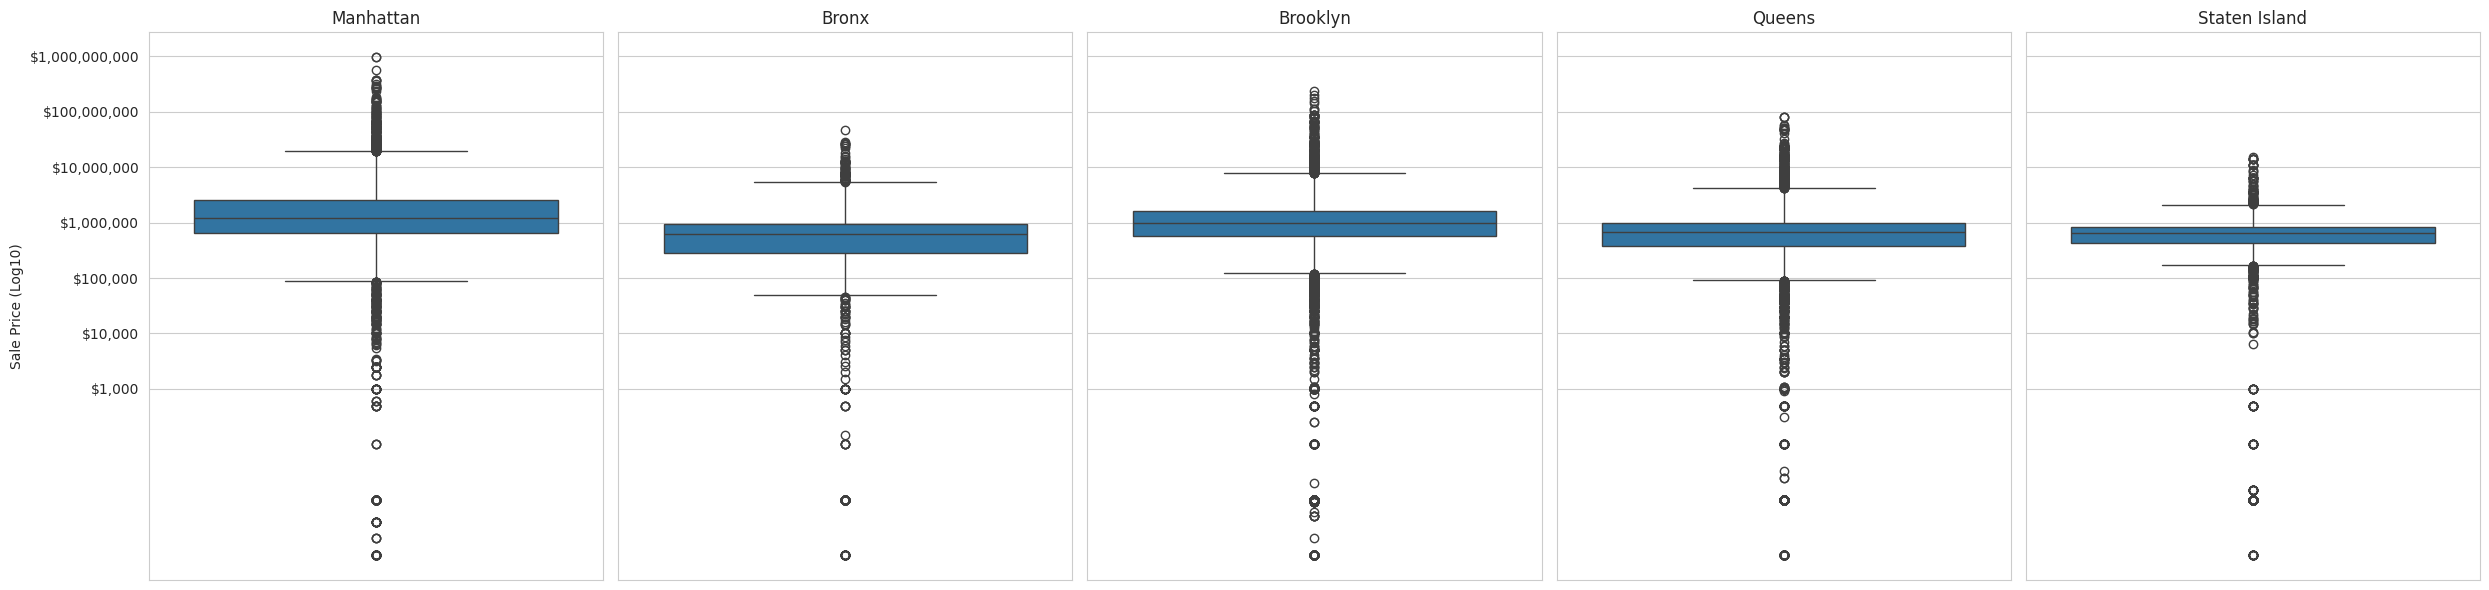

In [ ]:
### Removees any values less than 0.
df_2024 = df_2024[df_2024['sale_price'] > 0]

### For visulization purposes applies a log base 10 scale.
df_2024['log_sale_price'] = np.log10(df_2024['sale_price'])

### Creates the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True)

#### uses a four loop to iterate over the 5 different boroughs within the dataset
for ax, borough in zip(axes, borough_map.values()):
    sns.boxplot(
        data=df_2024[df_2024['borough'] == borough],
        y='log_sale_price',
        ax=ax
    )
    ax.set_title(borough)
    ax.set_xlabel('')
    ax.set_ylabel('Sale Price (Log10)' if borough == 'Manhattan' else '')

### format ticks back to dollars for reference
for ax in axes:
    ax.set_yticks(range(3, 10))  # 10^3 to 10^9
    ax.set_yticklabels([f"${10**y:,.0f}" for y in range(3, 10)])


plt.tight_layout()
plt.show()

Visualization for sales volume for the 2024 year

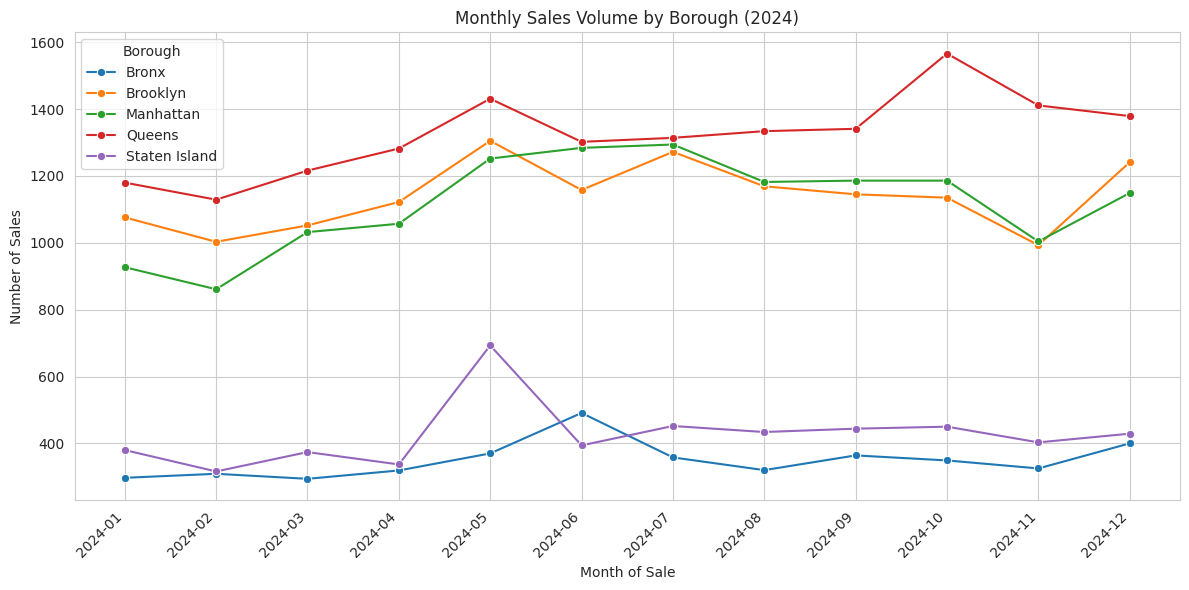

In [ ]:
### Prepare monthly counts
monthly_counts = (
    df_2024.groupby([df_2024['sale_date'].dt.to_period('M').astype(str), 'borough'])
           .size()
           .reset_index(name='count')
)

### Plot as line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='sale_date', y='count', hue='borough', marker='o')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Month of Sale')
plt.ylabel('Number of Sales')
plt.title('Monthly Sales Volume by Borough (2024)')
plt.legend(title='Borough', loc='best')

plt.tight_layout()
plt.show()

Price count bar graph

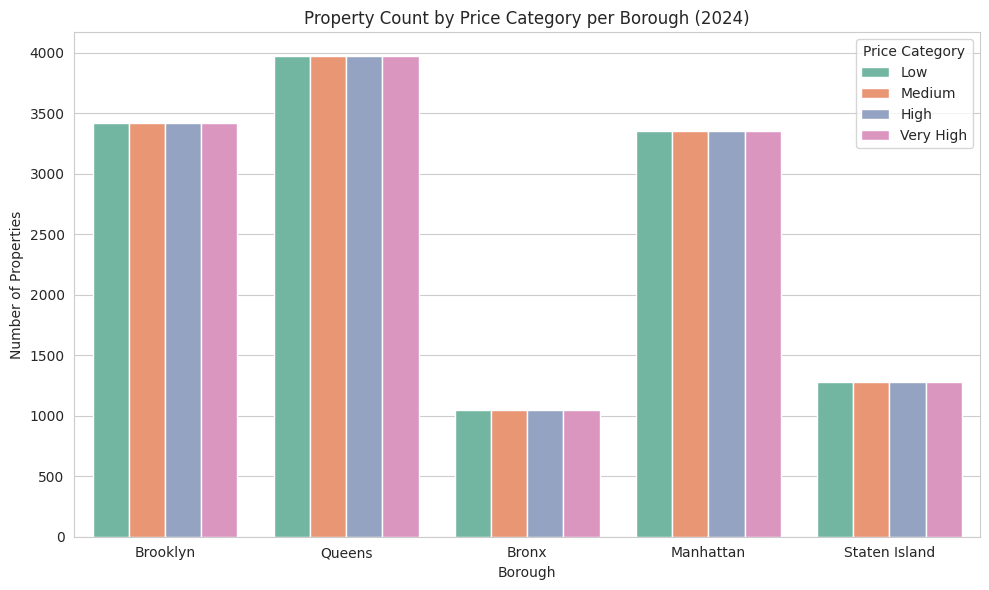

In [ ]:
df_2024['price_category'] = df_2024['price_category'].astype(str)

### Define category order
cat_order = CategoricalDtype(
    categories=['Low', 'Medium', 'High', 'Very High'],
    ordered=True
)

### Apply ordering to DataFrame
df_2024['price_category'] = df_2024['price_category'].astype(cat_order)

### Plot with hue_order to ensure order is respected
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_2024,
    x='borough',
    hue='price_category',
    hue_order=cat_order.categories,
    palette='Set2'
)

plt.title('Property Count by Price Category per Borough (2024)')
plt.xlabel('Borough')
plt.ylabel('Number of Properties')
plt.legend(title='Price Category')
plt.tight_layout()
plt.show()

In [ ]:
### Checks to ensure that groupings are 25% across the different bins.
df_2024.groupby(['borough', 'price_category']).size()

/tmp/ipython-input-3317876488.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_2024.groupby(['borough', 'price_category']).size()


borough        price_category
Bronx          Low               1049
               Medium            1049
               High              1049
               Very High         1049
Brooklyn       Low               3418
               Medium            3418
               High              3417
               Very High         3418
Manhattan      Low               3354
               Medium            3353
               High              3353
               Very High         3354
Queens         Low               3972
               Medium            3971
               High              3971
               Very High         3971
Staten Island  Low               1277
               Medium            1276
               High              1276
               Very High         1277
dtype: int64

Analysis

First Step - One hot encode borough variables

In [ ]:
borough_encoded = pd.get_dummies(df_2024['borough'], prefix='borough')
df_2024_encoded = pd.concat([df_2024, borough_encoded], axis=1)
print(df_2024_encoded.head())

        total_units   borough          neighborhood  zip_code  total_units  \
682684          3.0  Brooklyn   OCEAN PARKWAY-SOUTH   11223.0          3.0   
682687          3.0  Brooklyn  WILLIAMSBURG-CENTRAL   11206.0          3.0   
682698          2.0    Queens          HOLLIS HILLS   11427.0          2.0   
682706          2.0    Queens   SPRINGFIELD GARDENS   11434.0          2.0   
682714          NaN     Bronx  BEDFORD PARK/NORWOOD   10458.0          NaN   

       land_square_feet gross_square_feet  year_built  sale_price  sale_date  \
682684            1,801             3,840      1930.0          10 2024-01-01   
682687            2,000             2,432      1899.0      272000 2024-01-01   
682698            4,000             1,820      1960.0          10 2024-01-01   
682706            3,117             1,942      1985.0          10 2024-01-01   
682714              NaN               NaN      1955.0      100000 2024-01-02   

       price_category  log_sale_price  borough_Bro

Second Step - Label target and Features

In [ ]:
features = ["total_units", "land_square_feet", "gross_square_feet", "year_built", "borough_Bronx", "borough_Brooklyn", "borough_Manhattan","borough_Queens", "borough_Staten Island"]
taget = "price_category"

Remove any excess characters and convert to numeric

In [ ]:
### Edit to drop extra spacing
df_2024_encoded.columns = df_2024_encoded.columns.str.strip()

### Checks for duplicate columns
dups = df_2024_encoded.columns[df_2024_encoded.columns.duplicated()].unique()
print("Duplicate columns:", dups.tolist())

#### Drop duplicate-name columns, keeping the first occurrence
df_2024_encoded = df_2024_encoded.loc[:, ~df_2024_encoded.columns.duplicated()]
num_cols = ["total_units", "land_square_feet", "gross_square_feet", "year_built"]

for c in num_cols:
    df_2024_encoded[c] = pd.to_numeric(
        df_2024_encoded[c].astype(str).str.replace(r'[^\d\.\-]', '', regex=True),
        errors='coerce'
    )

Duplicate columns: []


Third Step - Split the data into features and targets, drop any 0 values

In [ ]:
X = df_2024_encoded[features]
y = df_2024_encoded[taget]
### Drop rows with missing values
mask = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]


Train and Split the Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

Apply standardization

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Creates and fits the models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    ### unsupervised
    "KMeans": KMeans(n_clusters=len(y_train.unique()), random_state=42)
}

### Fit models
for name, model in models.items():
    if name == "KMeans":
      ### No y for KMeans
        model.fit(X_train_scaled)
    else:
        model.fit(X_train_scaled, y_train)

print("All models trained.")

All models trained.


Cross Validation

In [ ]:
### Creates Dictonary for cross- validation
cv_results = {}

for name, model in models.items():
    if name != "KMeans":  ### Skip KMeans for supervised CV
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        cv_results[name] = np.mean(scores)

### Display results
for name, score in cv_results.items():
    print(f"{name}: {score:.4f}")

Logistic Regression: 0.4013
Naive Bayes: 0.3335
Decision Tree: 0.4389
Random Forest: 0.5109
SVM: 0.4385
KNN: 0.4801


Fit and train the model

In [ ]:
test_reports = {}
test_preds = {}

for name, model in models.items():
    if name == "KMeans":
        continue
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_preds[name] = y_pred
    test_reports[name] = classification_report(y_test, y_pred, output_dict=True)

pd.DataFrame({m: r['accuracy'] for m, r in test_reports.items()}, index=['accuracy']).T

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,accuracy
Logistic Regression,0.396165
Naive Bayes,0.343719
Decision Tree,0.433385
Random Forest,0.500352
SVM,0.436064
KNN,0.473002


Plot confusion matrix for top model

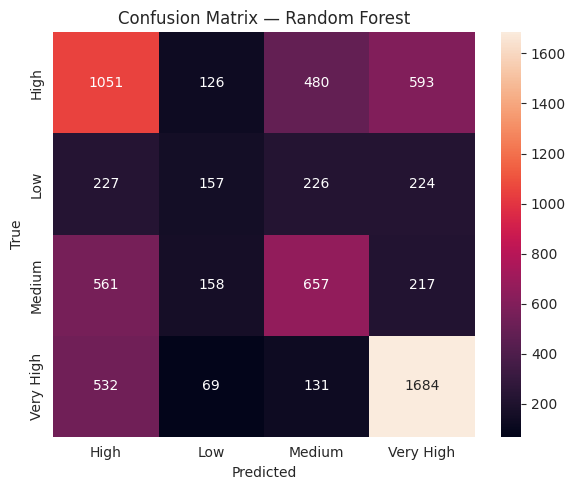

In [ ]:
best = max(test_reports, key=lambda m: test_reports[m]['accuracy'])
cm = confusion_matrix(y_test, test_preds[best], labels=sorted(y_test.unique()))
plt.figure(figsize=(6,5))
sns.heatmap(pd.DataFrame(cm, index=sorted(y_test.unique()), columns=sorted(y_test.unique())),
            annot=True, fmt='d')
plt.title(f'Confusion Matrix — {best}')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()


from sklearn.model_selection import GridSearchCV

rf_grid = {'n_estimators':[200,400],
           'max_depth':[None,10,20],
           'min_samples_split':[2,5]}
svm_grid = {'C':[0.5,1,2], 'gamma':['scale','auto'], 'kernel':['rbf']}

grids = {
    'Random Forest': (models['Random Forest'], rf_grid),
    'SVM': (models['SVM'], svm_grid)
}

best_models = {}
for name, (base, grid) in grids.items():
    gs = GridSearchCV(base, grid, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    best_models[name] = gs.best_estimator_
    print(name, gs.best_params_, gs.best_score_)

Summary output and Best Model Winner

In [ ]:

np.random.seed(42)

test_reports = {}
y_preds = {}
rows = []

for name, model in models.items():
    if name == "KMeans":
        continue
    ### single fit for both the table and winner
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_preds[name] = y_pred

    rep = classification_report(y_test, y_pred, output_dict=True)
    test_reports[name] = rep

    ### same as accuracy_score
    acc = rep['accuracy']
    prec_w, rec_w, f1_w = (rep['weighted avg']['precision'],
                           rep['weighted avg']['recall'],
                           rep['weighted avg']['f1-score'])
    rows.append({"model": name, "accuracy": acc,
                 "precision_w": prec_w, "recall_w": rec_w, "f1_w": f1_w})

summary = (pd.DataFrame(rows).set_index("model")
           .sort_values("f1_w", ascending=False))

### pick the winner from the  summary below
METRIC = "accuracy"
best_model_name = summary[METRIC].idxmax()
best_score = summary.loc[best_model_name, METRIC]

print(summary.round(4))
print(f"\nBest model: {best_model_name} ({METRIC} = {best_score:.4f})")

### Should match the output above. Previous versions were mismatched, this was placed as a checker.
from sklearn.metrics import accuracy_score
print("check:", accuracy_score(y_test, y_preds[best_model_name]),
                  test_reports[best_model_name]['accuracy'])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

                     accuracy  precision_w  recall_w    f1_w
model                                                       
Random Forest          0.5011       0.4877    0.5011  0.4918
KNN                    0.4730       0.4687    0.4730  0.4656
Decision Tree          0.4359       0.4383    0.4359  0.4371
SVM                    0.4361       0.4063    0.4361  0.3859
Logistic Regression    0.3962       0.3228    0.3962  0.3176
Naive Bayes            0.3437       0.3351    0.3437  0.2167

Best model: Random Forest (accuracy = 0.5011)
check: 0.5010573805160017 0.5010573805160017


Creates table Summary to add to streamlit

In [ ]:
### Moves it to summary for streamlit view.
summary_df.to_excel("model_results.xlsx", sheet_name="test_metrics_2024")

Saving winning model inorder to import to streamlit - Did not end up using but eneded up keeping for potential future use.

In [ ]:
### best by weighted F1 (or pick from tuning)
winner = summary.index[0]
final_model = models[winner] if winner not in best_model else best_model[winner]
final_model.fit(X_train_scaled, y_train)

### Save scaler + model + column order
joblib.dump({'scaler': preprocess if 'preprocess' in globals() else None,
             'columns': X_train.columns,
             'model': final_model},
            'price_category_model.joblib')
print("Saved to price_category_model.joblib")

Saved to price_category_model.joblib


Classification Reports

In [ ]:
report_data = []

for name, model in models.items():
    ### Skip unsupervised
    if name == "KMeans":
        continue

    ### Train on scaled training set
    model.fit(X_train_scaled, y_train)

    ### Predict on scaled test set
    y_pred = model.predict(X_test_scaled)

    ### Get classification report as a dict
    report = classification_report(y_test, y_pred, output_dict=True)

    ### Extract accuracy and weighted avg metrics
    report_data.append({
        'model': name,
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    })

    ### print full report for each model
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=2))

### Convert to DataFrame for easy plotting
df_reports = pd.DataFrame(report_data)

print("\nSummary Table:")
print(df_reports)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.36      0.62      0.45      2250
         Low       0.00      0.00      0.00       834
      Medium       0.26      0.00      0.01      1593
   Very High       0.44      0.58      0.50      2416

    accuracy                           0.40      7093
   macro avg       0.27      0.30      0.24      7093
weighted avg       0.32      0.40      0.32      7093


Naive Bayes Classification Report:
              precision    recall  f1-score   support

        High       0.33      0.98      0.50      2250
         Low       0.00      0.00      0.00       834
      Medium       0.04      0.00      0.00      1593
   Very High       0.64      0.10      0.17      2416

    accuracy                           0.34      7093
   macro avg       0.26      0.27      0.17      7093
weighted avg       0.34      0.34      0.22      7093


Decision Tree Classification Report:
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


SVM Classification Report:
              precision    recall  f1-score   support

        High       0.37      0.73      0.49      2250
         Low       0.00      0.00      0.00       834
      Medium       0.40      0.13      0.20      1593
   Very High       0.59      0.51      0.55      2416

    accuracy                           0.44      7093
   macro avg       0.34      0.34      0.31      7093
weighted avg       0.41      0.44      0.39      7093



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



KNN Classification Report:
              precision    recall  f1-score   support

        High       0.42      0.54      0.47      2250
         Low       0.27      0.15      0.20       834
      Medium       0.42      0.36      0.39      1593
   Very High       0.62      0.59      0.61      2416

    accuracy                           0.47      7093
   macro avg       0.43      0.41      0.41      7093
weighted avg       0.47      0.47      0.47      7093


Summary Table:
                 model  accuracy  precision    recall  f1-score
0  Logistic Regression  0.396165   0.322782  0.396165  0.317561
1          Naive Bayes  0.343719   0.335064  0.343719  0.216655
2        Decision Tree  0.435359   0.438383  0.435359  0.436790
3        Random Forest  0.502185   0.488241  0.502185  0.492489
4                  SVM  0.436064   0.406309  0.436064  0.385900
5                  KNN  0.473002   0.468716  0.473002  0.465629


Elbow Method K Mean

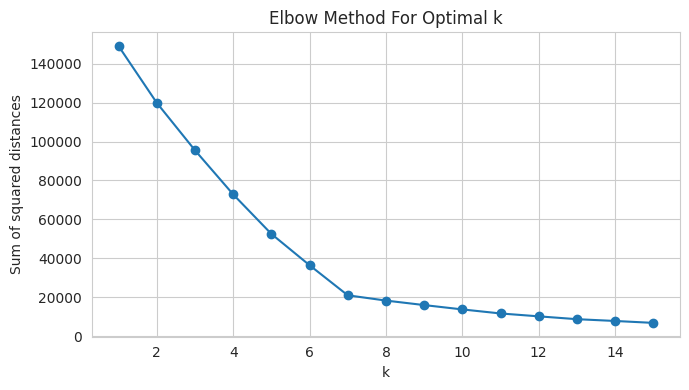

In [ ]:
### Use scaled training features
X_elbow = X_train_scaled

ks = range(1, 16)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_elbow)
    ### sum of squared distances to nearest cluster center
    inertias.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(list(ks), inertias, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.tight_layout()
plt.show()

K-Means Scores

In [ ]:
optimal_k = 7

### Fit K-Means on scaled features (train+test combined for unsupervised)
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
y_all = np.concatenate([y_train, y_test])  # to compare against all labels

km = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_labels = km.fit_predict(X_all_scaled)

### Compute metrics
ari = adjusted_rand_score(y_all, cluster_labels)
nmi = normalized_mutual_info_score(y_all, cluster_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Rand Index (ARI): 0.0090
Normalized Mutual Information (NMI): 0.0174


Classification report for each model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

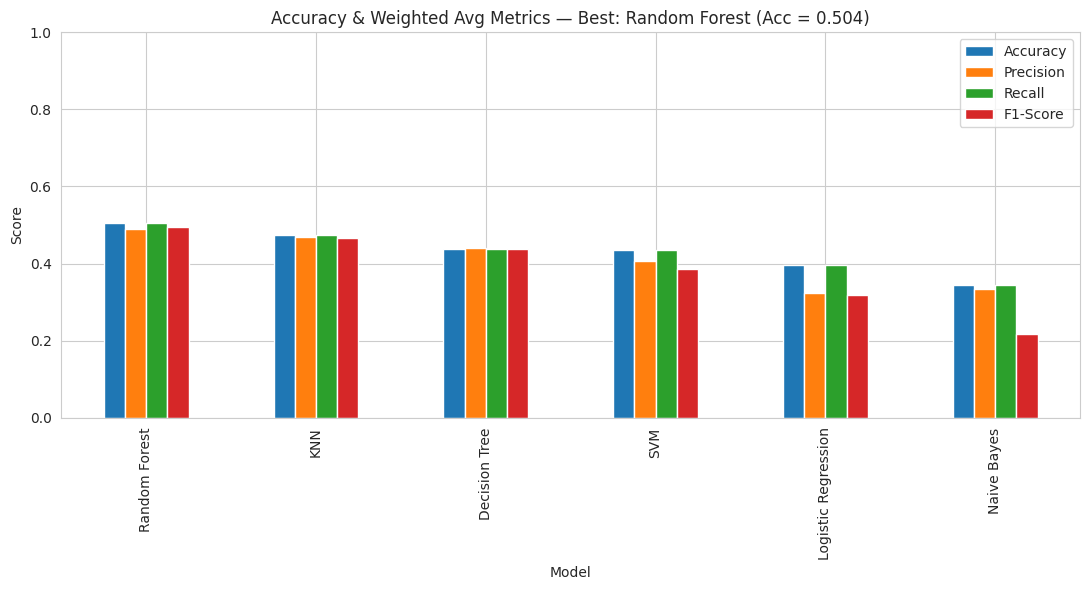

Best model: Random Forest  |  Accuracy: 0.5043


In [ ]:
metrics_list = []
best_name, best_acc = None, -1.0

for name, model in models.items():
    #### skip unsupervised here
    if name == "KMeans":
        continue
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)

    acc = report['accuracy']
    if acc > best_acc:
        best_acc = acc
        best_name = name

    metrics_list.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    })

metrics_df = pd.DataFrame(metrics_list).set_index('Model').sort_values('Accuracy', ascending=False)

ax = metrics_df.plot(kind='bar', figsize=(11,6))
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.legend(loc='best')
ax.set_title(f"Accuracy & Weighted Avg Metrics — Best: {best_name} (Acc = {best_acc:.3f})")
plt.tight_layout()
plt.show()

print(f"Best model: {best_name}  |  Accuracy: {best_acc:.4f}")

End of project
